# XYZ Corp. : Default Rate Prediction and Analysis

The notebook contains the ideal solution flow with full codes for Data Science Project of Imarticus. As per requirement it is completely written in python.

As per the problem statement, the steps that should be followed by the students are as follows :

- Exploratory Data Analysis (EDA)
  - Data Cleaning
  - Variable Transformations
  - Plots to study trends
- Feature engineering and Variable Selection
- Model Building and Validation
    - Preprocessing
    - Model Building, testing and validation
    - Model selection
- Final results

The codes for each of these steps are as follows:

In [37]:
# Loading all the required libraries

%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math


## Exploratory Data Analysis (EDA)

### Data Cleaning

In [38]:
data = pd.read_csv("XYZCorp_LendingData.csv")

data.shape

C:\Users\aakas\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (17,45,53) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(855969, 73)

Next up, we want to get rid of sparsely populated variables, so we remove columns with more that 75% missing values

In [39]:
var_null_pc = data.isnull().sum(axis=0).sort_values( ascending=False)/float(len(data) )
var_null_pc[ var_null_pc > 0.75 ]

dti_joint                      0.999486
verification_status_joint      0.999484
annual_inc_joint               0.999484
il_util                        0.986438
mths_since_rcnt_il             0.984890
total_bal_il                   0.984476
inq_last_12m                   0.984476
open_acc_6m                    0.984476
open_il_6m                     0.984476
open_il_24m                    0.984476
open_il_12m                    0.984476
open_rv_12m                    0.984476
open_rv_24m                    0.984476
max_bal_bc                     0.984476
all_util                       0.984476
inq_fi                         0.984476
total_cu_tl                    0.984476
desc                           0.857691
mths_since_last_record         0.846742
mths_since_last_major_derog    0.750997
dtype: float64

* We have 20 variables which we can remove from modelling and analysis
* We should also remove those observations where all values are NAs or nulls

In [40]:
data.drop( var_null_pc[ var_null_pc > 0.75 ].index, axis = 1, inplace = True ) 
data.dropna( axis = 0, thresh = 30, inplace = True )

After having a closer look at the data (and studying frequency tables), we can remove the following variables, reasons described:

1. policy_code is always == 1
2. payment_plan has only 10 y and 887372 n
3. id and member_id are all unique, which is a bit misleading. So every record is a unique customer
4. application_type is 'INDIVIDUAL' for 99.94% of the records
5. acc_now_delinq is 0 for 99.5% of the records
6. emp_title not needed here, but it might be useful for the modelling (see below),
7. zip_code not needed for this level of analysis,
8. title can be removed as well.


In [41]:
vars_to_be_removed = ['policy_code', 'pymnt_plan', 'id', 'member_id', 'application_type', 
                      'acc_now_delinq','emp_title', 'zip_code','title']

data.drop( vars_to_be_removed , axis = 1, inplace = True )

### Variable Transformations

To make a modelling ready dataset, we have to transform a few variables

A summary of the operations performed:

- Strip months from term and make it an integer
- Extract numbers from emp_length and fill missing values with the median. If emp_length == 10+ years then leave it as 10
- Transform datetimes to a Period


In [42]:
# strip months from 'term' and make it an int
data['term'] = data['term'].str.split(' ').str[1]

# extract numbers from emp_length and fill missing values with the median
data['emp_length'] = data['emp_length'].str.extract('(\d+)').astype(float)
data['emp_length'] = data['emp_length'].fillna(data.emp_length.median())

col_dates = data.dtypes[data.dtypes == 'datetime64[ns]'].index
for d in col_dates:
    data[d] = data[d].dt.to_period('M')

### Plots to study trends

#### Categorical variables

In [43]:
# A helper function which can be used to visualize the categorical variables

def make_bar(attr, title, ylabel):
    heights = data[attr].value_counts().tolist()
    names = []
    for k, v in data[attr].value_counts().items():
        names.append(k)
        
    for ii, height in enumerate(heights):
        color = np.random.random_sample(3)
        plt.bar(ii, height, color=color)
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.gca().set_xticklabels(names)
    plt.gca().set_xticks(np.arange(len(names)) + .4)
    
    if len(names) > 5:
        plt.xticks(rotation=90)
    plt.show()
    

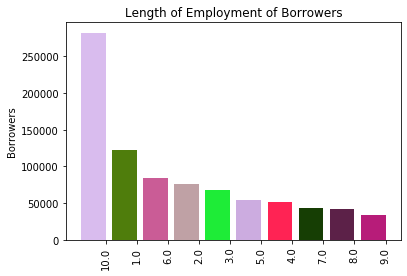

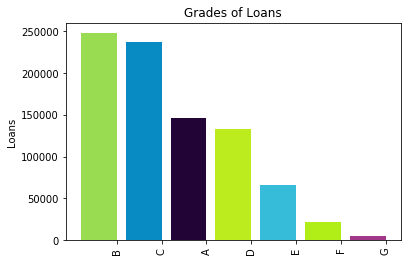

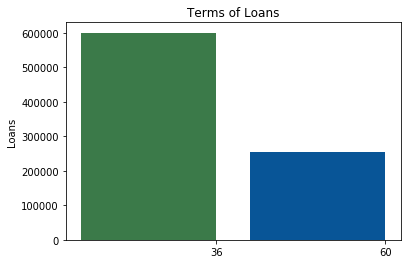

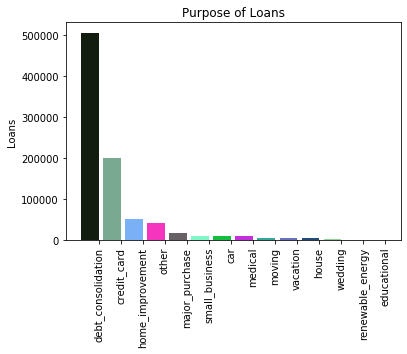

In [44]:
# We plot different variables to visualize them

make_bar('emp_length', 'Length of Employment of Borrowers', 'Borrowers')
make_bar('grade', 'Grades of Loans', 'Loans')
make_bar('term', 'Terms of Loans', 'Loans')
make_bar('purpose', 'Purpose of Loans', 'Loans')

#### Numerical variables

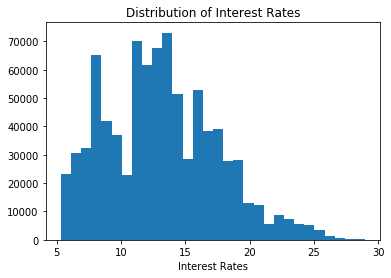

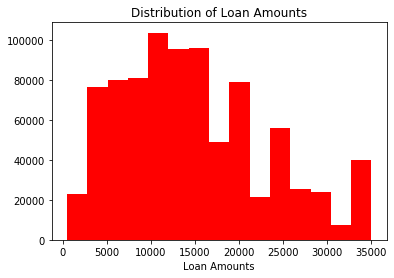

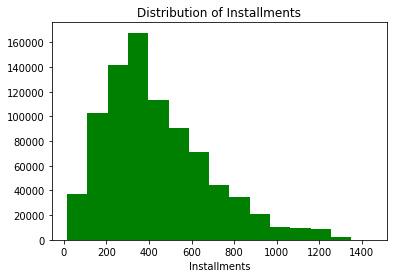

In [45]:
plt.hist(data['int_rate'], bins=30)
plt.title('Distribution of Interest Rates')
plt.xlabel("Interest Rates")
plt.show()

plt.hist(data['loan_amnt'], bins=15, color='red')
plt.title('Distribution of Loan Amounts')
plt.xlabel("Loan Amounts")
plt.show()

plt.hist(data['installment'], bins=15, color='green')
plt.title('Distribution of Installments')
plt.xlabel("Installments")
plt.show()

### Feature Engineering and Variable Selection

We can finally choose the metrics for the model remembering to check for missing values and transforming metrics in a way suitable for modelling.

- Let's keep the loan_amount, but let's create a metric which indicates that the total amount committed by investors for that loan at that point in time (funded_amnt_inv) is less than what the borrower requested.
- The interest rate is an important metrics, but it changes with time, whereas the interest grade does not. So, we will consider the interest grade only, exluding the sub_grade to keep it simple.
- The metrics delinq_2yrs is very skewed towards zero (80% are zeros). Let's make it categorical: no when delinq_2yrs == 0 and yes when delinq_2yrs > 0
- Same as above for inq_last_6mths: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
- Same as above for pub_rec: Number of derogatory public records
- I thought about computing difference between the date of the earliest credit line and the issue date df['tmp'] = df.earliest_cr_line - df.issue_d, but I do not understand the metrics well, so I will skip this
- Let's compute the ratio of the number of open credit lines in the borrower's credit file divided by the total number of credit lines currently in the borrower's credit file



In [46]:
data['amt_difference'] = 'eq'
data.loc[ ( data['funded_amnt'] - data['funded_amnt_inv']) > 0, 'amt_difference' ] = 'less'

# Make categorical

data[ 'delinq_2yrs_cat' ] = 'no'
data.loc[ data [ 'delinq_2yrs' ] > 0, 'delinq_2yrs_cat' ] = 'yes'

data[ 'inq_last_6mths_cat' ] = 'no'
data.loc[ data['inq_last_6mths' ] > 0, 'inq_last_6mths_cat' ] = 'yes'

data[ 'pub_rec_cat' ] = 'no'
data.loc[ data['pub_rec'] > 0,'pub_rec_cat' ] = 'yes'

# Create new metric
data['acc_ratio'] = data.open_acc / data.total_acc

Finally the feature that we want to use to model default are as follows :

In [47]:
features = [
            'loan_amnt', 'amt_difference', 'term', 
            'installment', 'grade','emp_length',
            'home_ownership', 'annual_inc','verification_status',
            'purpose', 'dti', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 
            'open_acc', 'pub_rec', 'pub_rec_cat', 'acc_ratio', 'initial_list_status',
            'issue_d','default_ind'
           ]

data = data[features]

# Drop any residual missing values
data.dropna( axis=0, how = 'any', inplace = True )

Divide the data into model training dataset and OOT (out-of-time) test dataset.
The model training dataset should be used to train and build models and the final performance should be on OOT Test data.

In [48]:
oot_test_months = ['Jun-2015', 'Jul-2015', 'Aug-2015', 'Sep-2015', 'Oct-2015', 'Nov-2015', 'Dec-2015']

train = data.loc [ -data.issue_d.isin(oot_test_months) ]
oot_test = data.loc [ data.issue_d.isin(oot_test_months) ]

Convert categorical variables by one hot encoding so that they can be used by the models.

In [49]:
categorical_features = ['term','amt_difference', 'grade', 'home_ownership', 'verification_status', 
                            'purpose', 'delinq_2yrs_cat', 'inq_last_6mths_cat', 'initial_list_status', 'pub_rec_cat']

Converting categorical variable into dummy variable so that they can be used in the models

In [50]:
X_model_train = pd.get_dummies(train[train.columns[:-2]], columns=categorical_features).astype(float)
y_model_train = train['default_ind']

X_oot_test = pd.get_dummies(oot_test[oot_test.columns[:-2]], columns=categorical_features).astype(float)
y_oot_test = oot_test['default_ind']

print(X_model_train.shape, X_oot_test.shape)

(855969, 50) (0, 8)


Above we see that there is a mismatch in the number of columns in model training and OOT test data. This is because there are some categories in some variables that are present in the training dataset but not OOT test. We should remove those variables from training data to avoid errors later.

In [51]:
vars_not_in_oot_test = ['home_ownership_OWN','home_ownership_RENT','purpose_educational']

X_model_train.drop( vars_not_in_oot_test , axis = 1, inplace = True )

print(X_model_train.shape)

(855969, 47)


In [52]:
X_oot_test

,loan_amnt,installment,emp_length,annual_inc,dti,open_acc,pub_rec,acc_ratio


## Model Building and Validation


Let's start modelling by importing a few modules. Features are all on different scale, so it is wise to rescale all features in the range -1, +1


### Preprocessing

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE

X_scaled_model_train = preprocessing.scale(X_model_train)
X_scaled_oot_test = preprocessing.scale(X_oot_test)

print(X_scaled_model_train.shape, X_scaled_oot_test.shape)

ValueError: Found array with 0 sample(s) (shape=(0, 8)) while a minimum of 1 is required by the scale function.

### Model Building, testing and validation

The below function can be used to run different modelling techniques and study the performance (emperically and visually)

In [ ]:
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10)
            }
    cols = ['model', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

We first try with the data as-is

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled_model_train, y_model_train.values, 
                                                    test_size=0.4, random_state=0)

models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')

A look at the performance tells us that the techniques are not peforming well as the recall is very poor. An important reason for this can be that the classes are unbalanced. So we will try another iteration but this time by balancing classes.

> NOTE : Here is where a good business understanding of the practical situation comes in handy, getting good recall is more important than getting good precision, because as a banker I would be more concerned about catching more defaulters to minimize my losses rather than being very right all the time!

In [ ]:
models_report

To balance classes before training again, I will use the SMOTE technique. 

> NOTE : Even if students use other methods or just simple over sampling or undersampling its fine, as long as they have understood that the classes are unbalanced and they need to be more balanced for better performance.

In [ ]:
index_split = int(len(X_scaled_model_train)/2)
X_train, y_train = SMOTE().fit_sample(X_scaled_model_train[0:index_split, :], y_model_train[0:index_split])
X_test, y_test = X_scaled_model_train[index_split:], y_model_train[index_split:]

models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')

Even though the precision has dropped, we can see that there is a huge improvement in recall, this shows how balancing classes can improve performance.

In [ ]:
models_report_bal

> Based on the above, we will choose Logistic Regression as it performs better overall across metrics.

## Final Model

Now for the final model validation, the whole of model training dataset will be used for training and the validation will be done on OOT test data. Also, we modify the above function to run only for logistic as that is the model that we require here.

In [ ]:
def run_logistic(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):
    
    clfs = {
                'LogisticRegression' : LogisticRegression(),
            }
    cols = ['model', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')
    
    return models_report, conf_matrix

In [ ]:
X_train, y_train = SMOTE().fit_sample(X_scaled_model_train, y_model_train)
X_test, y_test = X_scaled_oot_test, y_oot_test

models_report_oot, conf_matrix_oot = run_logistic(X_train, y_train, X_test, y_test, model_type = 'Balanced')

The Report and confusion matrix for the final model.

In [ ]:
models_report_oot

In [ ]:
conf_matrix_oot['LogisticRegression']

If a student tries to play with the cut-off to determine the final logistic model, that is alright too.